In [1]:
import pandas as pd
import numpy as np

import datetime
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

import seaborn as sns
sns.set(rc={'figure.figsize':(24, 12)}, font_scale=2.2)
sns.set_style(style='whitegrid')

import math

from tqdm import tqdm

import sys
sys.path.append('../')
import utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def get_eval_measures_offline(alerts_df, regions_df, outlier_bounds=False): 
    '''
    Returns the range-based precision, recall and f1-scores of the raised alerts

    Note that the number of rows in alerts_df must be equal to the number of rows in regions_df
    '''
    real_ranges = []
    predicted_ranges = []

    # Get real ranges from regions_df
    for _, real_range_row in regions_df.iterrows():
        real_range = [real_range_row['unix_start'], real_range_row['unix_end']]
        real_ranges.append(real_range)

    # Get predicted ranges
    for _, predicted_range_row in alerts_df.iterrows():
        if outlier_bounds:
            predicted_range = [predicted_range_row['point_start'], predicted_range_row['point_end']]
        else:
            predicted_range = [predicted_range_row['start'], predicted_range_row['end']]
        predicted_ranges.append(predicted_range)
    
    precision = utils.metrics.range_based_precision(real_ranges, predicted_ranges)
    recall = utils.metrics.range_based_recall(real_ranges, predicted_ranges)
    f1_score = utils.helpers.compute_f1_score(precision, recall)

    return precision, recall, f1_score 

# Fixed Region Length and 100% Injection Rate

In [4]:
num_injected_regions=10

mode_to_mode_label = {
    'fixed_bandwidth': 'Fixed',
    'isj_bandwidth': 'ISJ',
    'isj_bandwidth_adj_local_min': 'ISJ + Adj. Local Min.',
    'mdi': 'MDI'
}

In [5]:
input_dir = '../synthetic_data/synthetic_experiments/all_outlier_types_098/'

eval_df_columns = ['mode', 'seed', 'Precision', 'Recall', 'F1 Score']
eval_df = pd.DataFrame(columns=eval_df_columns)

for seed in tqdm(sorted(os.listdir(input_dir))):
    for mode in os.listdir(input_dir + seed + '/evaluation/'):
        if mode == 'mdi':
            df = df = pd.read_pickle(input_dir + seed + '/df.pickle')
            regions_df = pd.read_pickle(input_dir + seed + '/regions_df.pickle')
            regions_df = utils.alerts.update_regions_df(regions_df, df)
            
            clusters_df = pd.read_pickle(input_dir + seed + '/evaluation/'+ mode + '/mdi_clusters_df.pickle')
            clusters_df = clusters_df.sort_values(by='score', ascending=False).head(num_injected_regions)
            precision, recall, f1_score = get_eval_measures_offline(alerts_df=clusters_df, regions_df=regions_df)
            eval_df.loc[len(eval_df.index)] = [mode_to_mode_label[mode], seed, precision, recall, f1_score]

        else:
            df = pd.read_pickle(input_dir + seed + '/evaluation/'+ mode + '/outputs/size_10080/df.pickle')

            regions_df = pd.read_pickle(input_dir + seed + '/regions_df.pickle')
            regions_df = utils.alerts.update_regions_df(regions_df, df)

            clusters_df = pd.read_pickle(input_dir + seed + '/evaluation/'+ mode + '/outputs/size_10080/clusters_df.pickle')
            clusters_df = clusters_df.sort_values(by='area', ascending=False).head(num_injected_regions)

            precision, recall, f1_score = get_eval_measures_offline(alerts_df=clusters_df, regions_df=regions_df)
            precision_outlier_bounds, recall_outlier_bounds, f1_score_outlier_bounds = get_eval_measures_offline(alerts_df=clusters_df, regions_df=regions_df, outlier_bounds=True)

            eval_df.loc[len(eval_df.index)] = [mode_to_mode_label[mode], seed, precision, recall, f1_score]
            eval_df.loc[len(eval_df.index)] = [mode_to_mode_label[mode] + ' + Outlier Bounds', seed, precision_outlier_bounds, recall_outlier_bounds, f1_score_outlier_bounds]

eval_df.head()

100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


,mode,seed,Precision,Recall,F1 Score
0,Fixed,seed1,0.157430,0.970833,0.270927
1,Fixed + Outlier Bounds,seed1,0.484366,0.935417,0.638244
2,MDI,seed1,0.152222,0.400000,0.220523
3,ISJ + Adj. Local Min.,seed1,0.530147,1.000000,0.692936
4,ISJ + Adj. Local Min. + Outlier Bounds,seed1,0.904869,0.941667,0.922901


In [6]:
eval_df_melt = pd.melt(eval_df, id_vars=['mode', 'seed'], value_vars=['Precision', 'Recall', 'F1 Score'])
modes_order=['Fixed', 'Fixed + Outlier Bounds', 'ISJ', 'ISJ + Outlier Bounds', 'ISJ + Adj. Local Min.', 'ISJ + Adj. Local Min. + Outlier Bounds', 'MDI']
eval_df_melt['mode'] = pd.Categorical(eval_df_melt['mode'], categories=modes_order)
eval_df_melt = eval_df_melt.sort_values('mode')
eval_df_melt

,mode,seed,variable,value
0,Fixed,seed1,Precision,0.157430
49,Fixed,seed7,Precision,0.150287
133,Fixed,seed9,Recall,0.970833
182,Fixed,seed6,F1 Score,0.219588
70,Fixed,seed1,Recall,0.970833
...,...,...,...,...
156,MDI,seed2,F1 Score,0.324319
121,MDI,seed7,Recall,0.097917
30,MDI,seed4,Precision,0.000000
79,MDI,seed10,Recall,0.100000


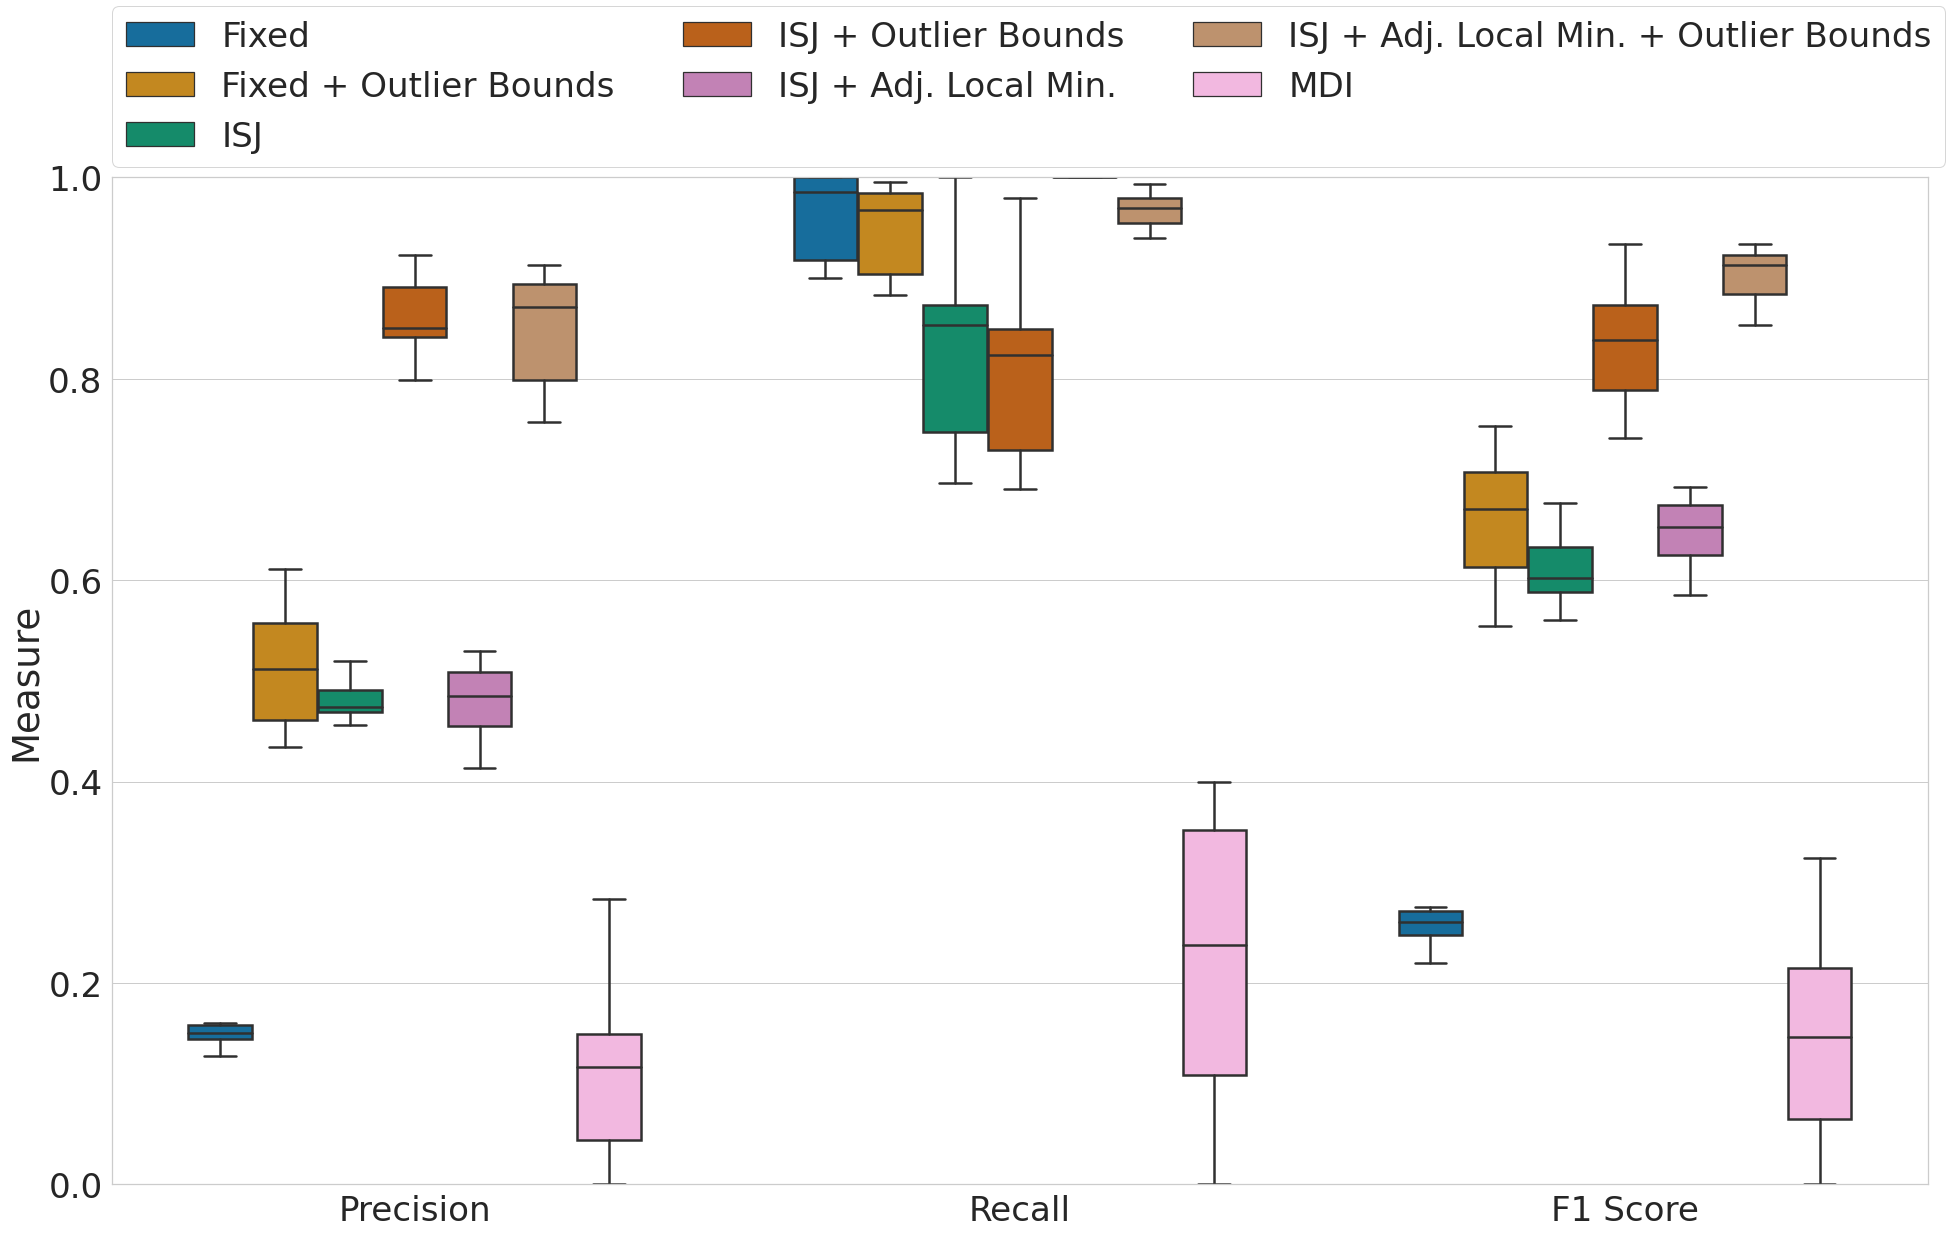

In [9]:
order=['Precision', 'Recall', 'F1 Score']
sns.set(rc={'figure.figsize':(30, 18)}, font_scale=3.1)
sns.set_style(style='whitegrid')
ax = sns.boxplot(x="variable", y="value", hue='mode', data=eval_df_melt, showfliers=False, order=order, linewidth=2.5, width=0.75, palette='colorblind')

#TODO: Maybe add hatches for each 

plt.legend(bbox_to_anchor=(0, 1.17), loc=2, borderaxespad=0.,ncol=3)
plt.ylim(0,1);plt.xlabel("");plt.ylabel("Measure");plt.title("");plt.tight_layout()
plt.savefig('figures/experiments/synthetic/offline/evaluation_box_plot_across_modes.svg')
plt.savefig('figures/experiments/synthetic/offline/evaluation_box_plot_across_modes.pdf')

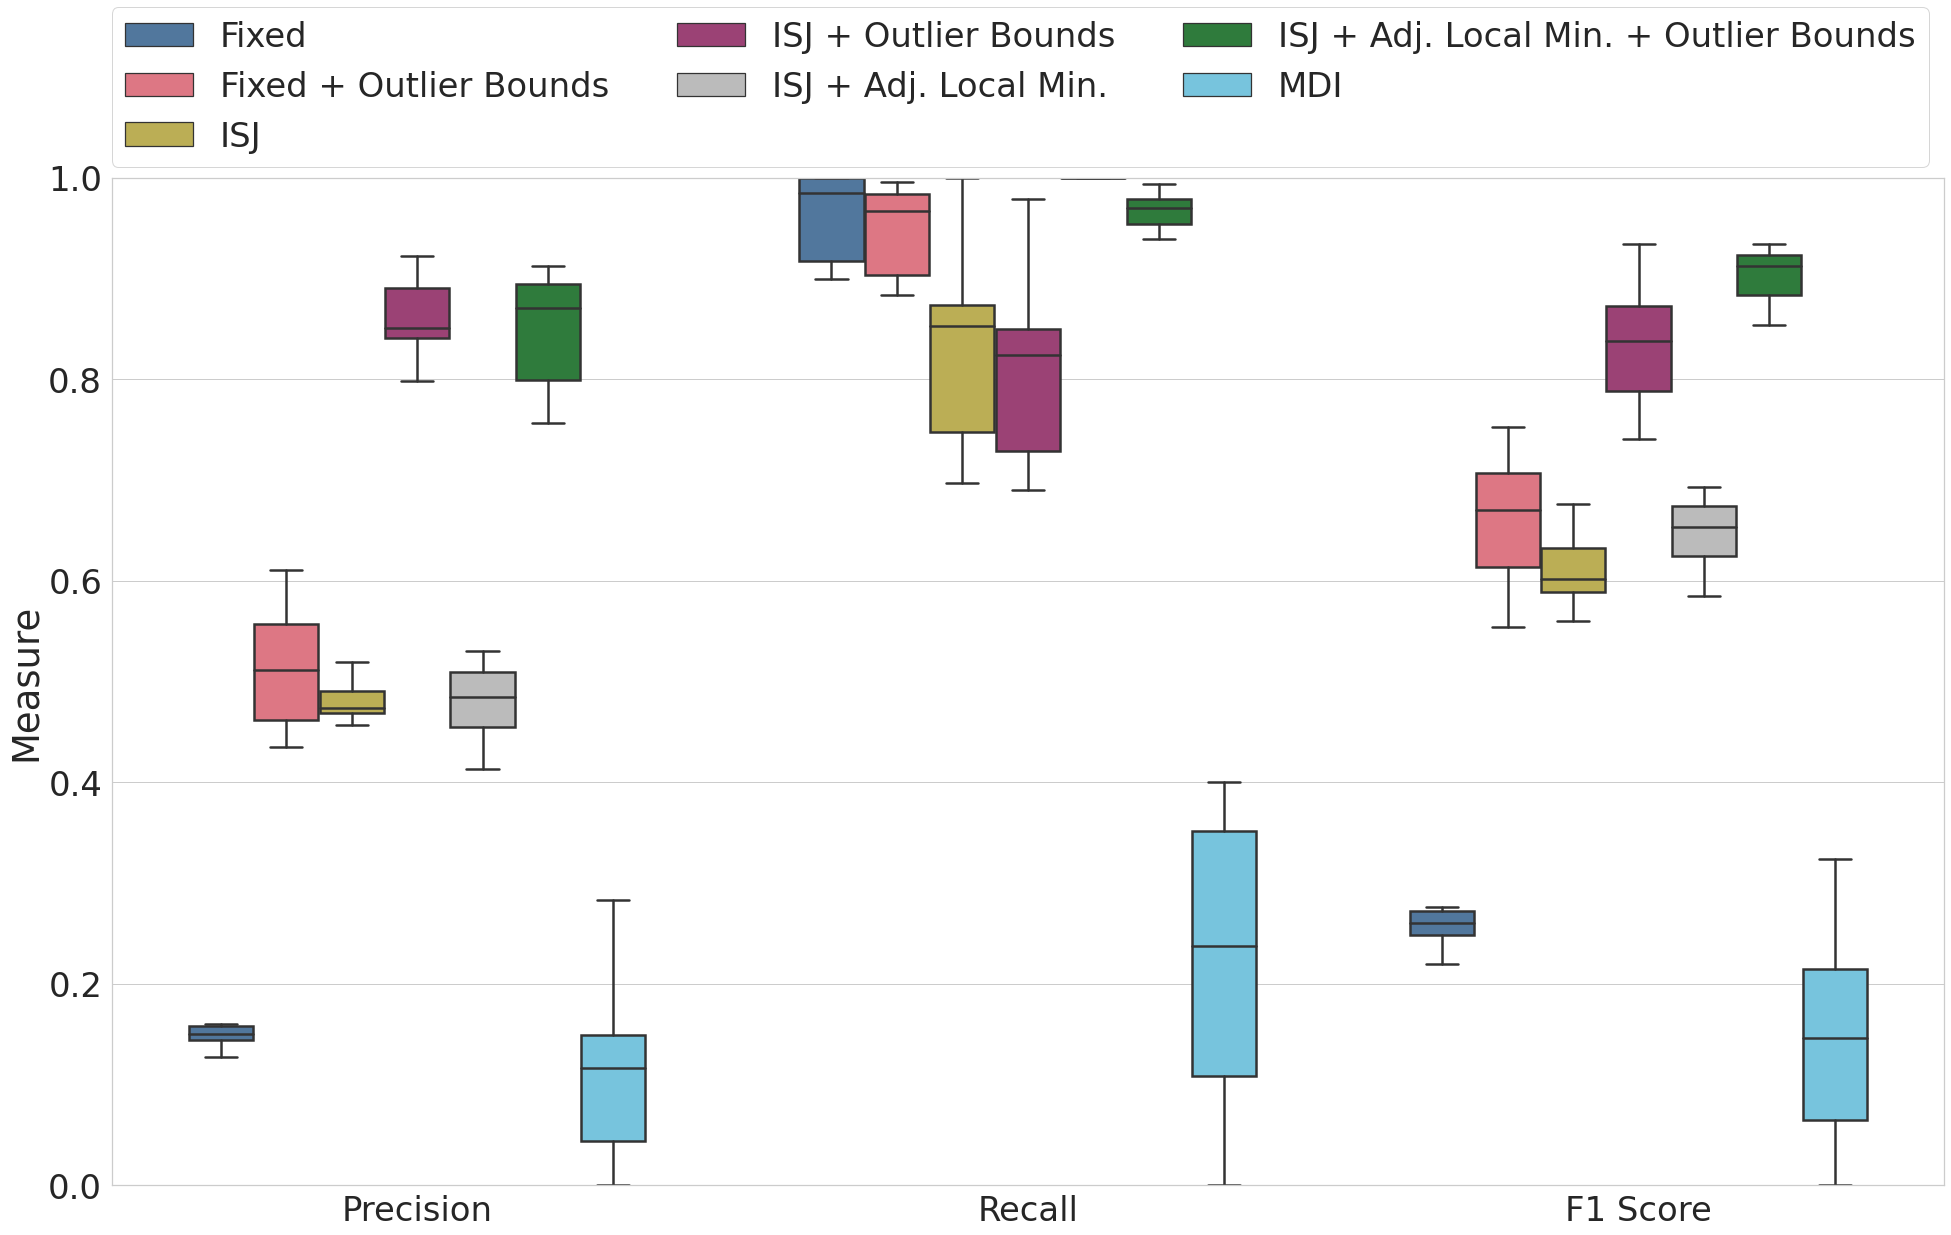

In [18]:
# Palette taken from: https://personal.sron.nl/~pault/#sec:qualitative
palette = ['#4477AA', '#EE6677', '#CCBB44', '#AA3377', '#BBBBBB', '#228833', '#66CCEE']

order=['Precision', 'Recall', 'F1 Score']
sns.set(rc={'figure.figsize':(30, 18)}, font_scale=3.08)
sns.set_style(style='whitegrid')
ax = sns.boxplot(x="variable", y="value", hue='mode', data=eval_df_melt, showfliers=False, order=order, linewidth=2.5, width=0.75, palette=sns.color_palette(palette, 7))
plt.legend(bbox_to_anchor=(0, 1.17), loc=2, borderaxespad=0.,ncol=3)
plt.ylim(0,1);plt.xlabel("");plt.ylabel("Measure");plt.title("");plt.tight_layout()
plt.savefig('figures/experiments/synthetic/offline/evaluation_box_plot_across_modes.svg')
plt.savefig('figures/experiments/synthetic/offline/evaluation_box_plot_across_modes.pdf')

# Variable Region Length and 100% Injection Rate

In [19]:
input_dir = '../synthetic_data/synthetic_experiments/variable_region_length/'

eval_df_columns = ['mode', 'seed', 'region_length_variability', 'Precision', 'Recall', 'F1 Score']
eval_df = pd.DataFrame(columns=eval_df_columns)

for region_length_dir in tqdm(os.listdir(input_dir)):
    region_length_variability = int(region_length_dir.split('_')[2]) - int(region_length_dir.split('_')[1])

    for seed in os.listdir(input_dir+region_length_dir+'/'):
        for mode in os.listdir(input_dir + region_length_dir + '/' + seed + '/evaluation/'):
            if mode == 'mdi':
                df = df = pd.read_pickle(input_dir + region_length_dir + '/' + seed + '/df.pickle')
                regions_df = pd.read_pickle(input_dir + region_length_dir + '/' + seed + '/regions_df.pickle')
                regions_df = utils.alerts.update_regions_df(regions_df, df)
                
                clusters_df = pd.read_pickle(input_dir + region_length_dir + '/' + seed + '/evaluation/'+ mode + '/mdi_clusters_df.pickle')
                clusters_df = clusters_df.sort_values(by='score', ascending=False).head(num_injected_regions)
                precision, recall, f1_score = get_eval_measures_offline(alerts_df=clusters_df, regions_df=regions_df)
                eval_df.loc[len(eval_df.index)] = [mode_to_mode_label[mode], seed, region_length_variability, precision, recall, f1_score]
            else:
                df = pd.read_pickle(input_dir + region_length_dir + '/' + seed + '/evaluation/'+ mode + '/outputs/size_10080/df.pickle')

                regions_df = pd.read_pickle(input_dir + region_length_dir + '/' + seed + '/regions_df.pickle')
                regions_df = utils.alerts.update_regions_df(regions_df, df)

                clusters_df = pd.read_pickle(input_dir + region_length_dir + '/' + seed + '/evaluation/'+ mode + '/outputs/size_10080/clusters_df.pickle')
                clusters_df = clusters_df.sort_values(by='area', ascending=False).head(num_injected_regions)

                precision, recall, f1_score = get_eval_measures_offline(alerts_df=clusters_df, regions_df=regions_df)
                precision_outlier_bounds, recall_outlier_bounds, f1_score_outlier_bounds = get_eval_measures_offline(alerts_df=clusters_df, regions_df=regions_df, outlier_bounds=True)

                eval_df.loc[len(eval_df.index)] = [mode_to_mode_label[mode], seed, region_length_variability,precision, recall, f1_score]
                eval_df.loc[len(eval_df.index)] = [mode_to_mode_label[mode] + ' + Outlier Bounds', seed, region_length_variability, precision_outlier_bounds, recall_outlier_bounds, f1_score_outlier_bounds]

eval_df

100%|██████████| 11/11 [00:29<00:00,  2.72s/it]


,mode,seed,region_length_variability,Precision,Recall,F1 Score
0,Fixed,seed7,28,0.186205,0.951630,0.311466
1,Fixed + Outlier Bounds,seed7,28,0.357637,0.950278,0.519689
2,MDI,seed7,28,0.294814,0.373476,0.329515
3,ISJ + Adj. Local Min.,seed7,28,0.560971,1.000000,0.718746
4,ISJ + Adj. Local Min. + Outlier Bounds,seed7,28,0.908121,0.981074,0.943189
...,...,...,...,...,...,...
765,MDI,seed3,32,0.376800,0.468063,0.417502
766,ISJ + Adj. Local Min.,seed3,32,0.616031,0.985185,0.758055
767,ISJ + Adj. Local Min. + Outlier Bounds,seed3,32,0.932453,0.951149,0.941708
768,ISJ,seed3,32,0.614911,0.602231,0.608505


In [20]:
modes_order=['Fixed', 'Fixed + Outlier Bounds', 'ISJ', 'ISJ + Outlier Bounds', 'ISJ + Adj. Local Min.', 'ISJ + Adj. Local Min. + Outlier Bounds', 'MDI']
eval_df['mode'] = pd.Categorical(eval_df['mode'], categories=modes_order)

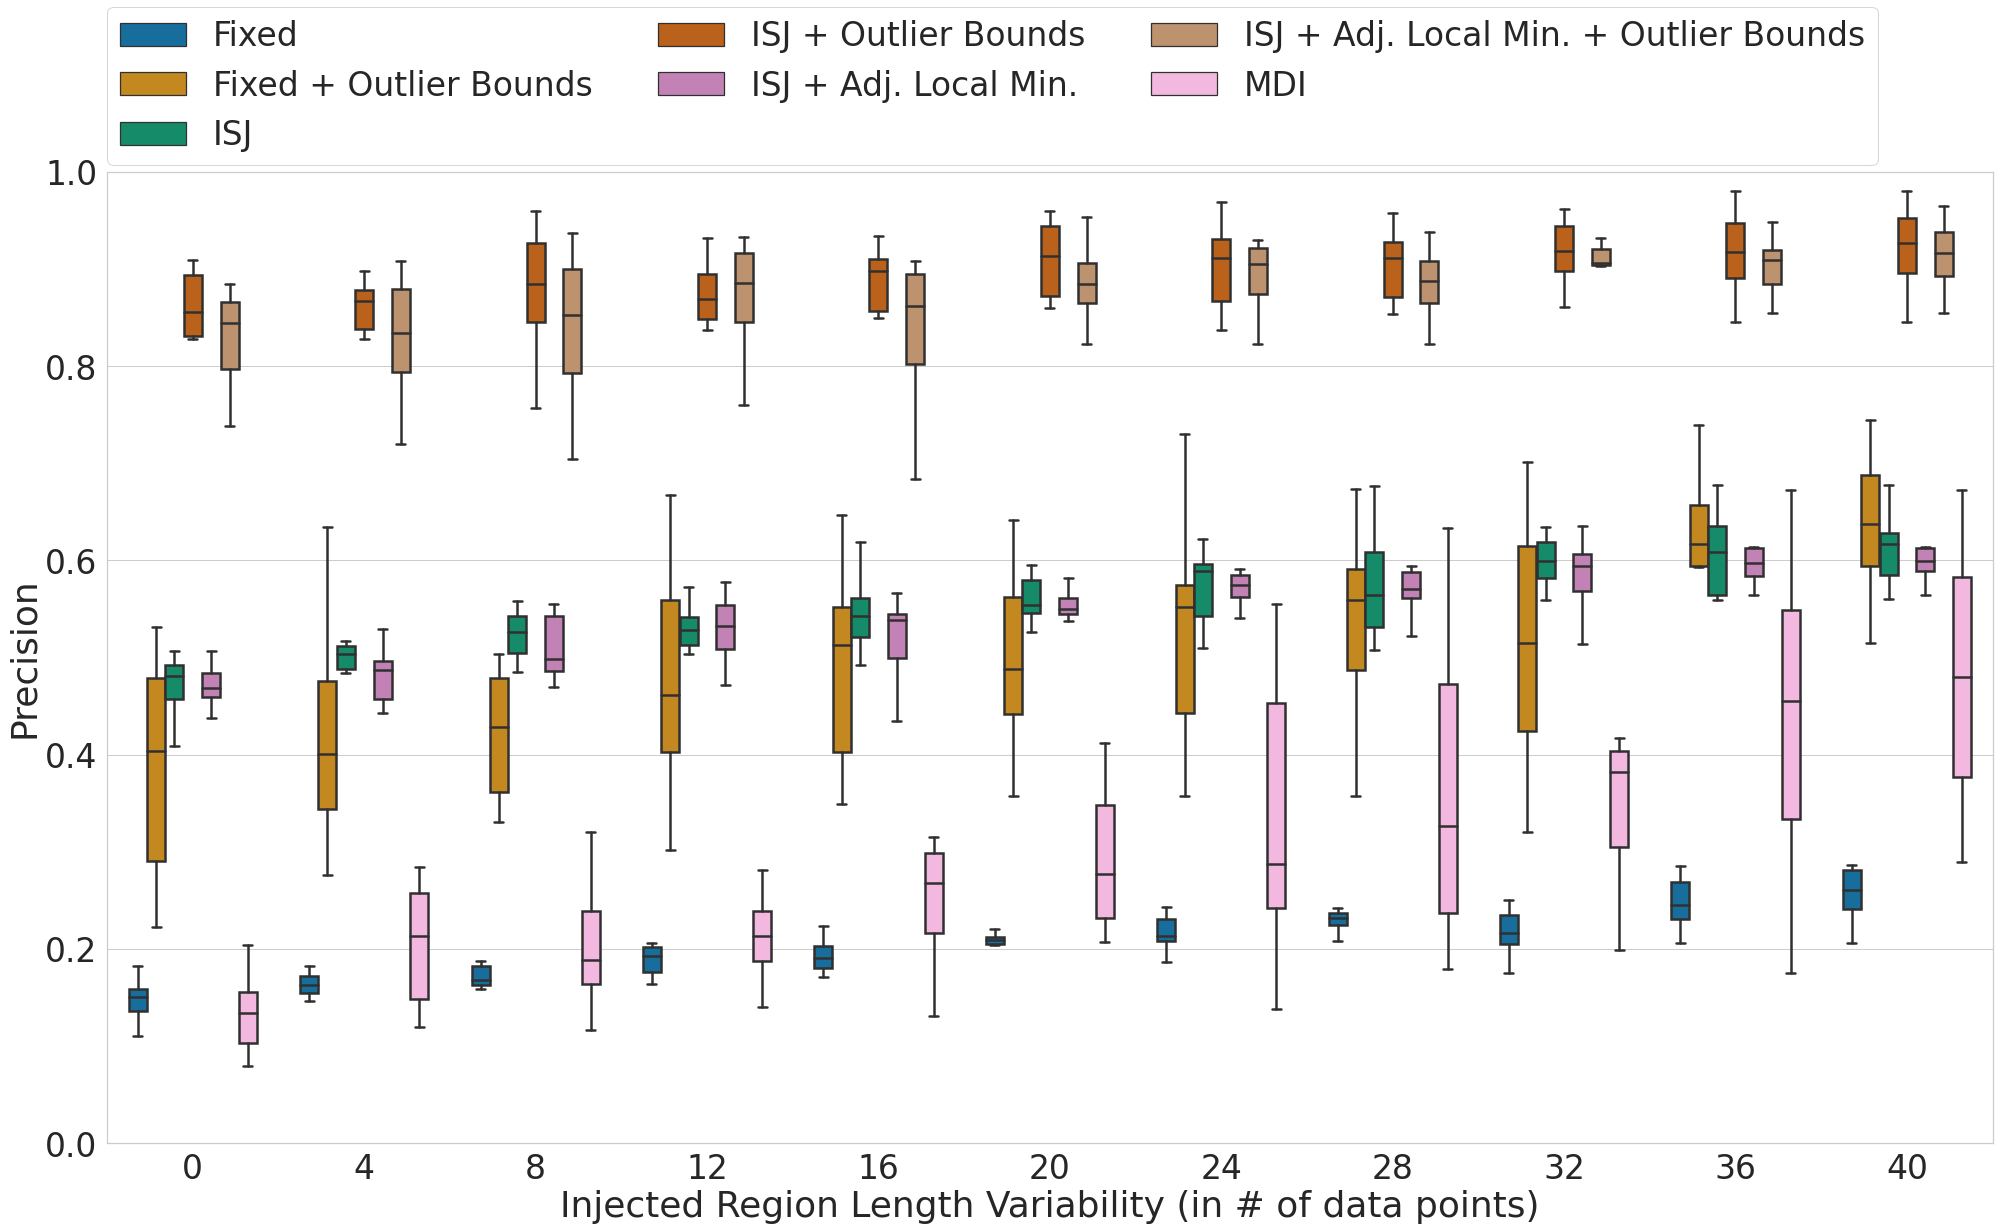

In [21]:
sns.set(rc={'figure.figsize':(30, 18)}, font_scale=3)
sns.set_style(style='whitegrid')
ax = sns.boxplot(x="region_length_variability", y="Precision", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette='colorblind')

plt.legend(bbox_to_anchor=(0, 1.17), loc=2, borderaxespad=0.,ncol=3)
plt.ylim(0,1);plt.xlabel("Injected Region Length Variability (in # of data points)");plt.ylabel("Precision");plt.title("");plt.tight_layout()
plt.savefig('figures/experiments/synthetic/offline/variable_region_length_precision.svg')
plt.savefig('figures/experiments/synthetic/offline/variable_region_length_precision.pdf')

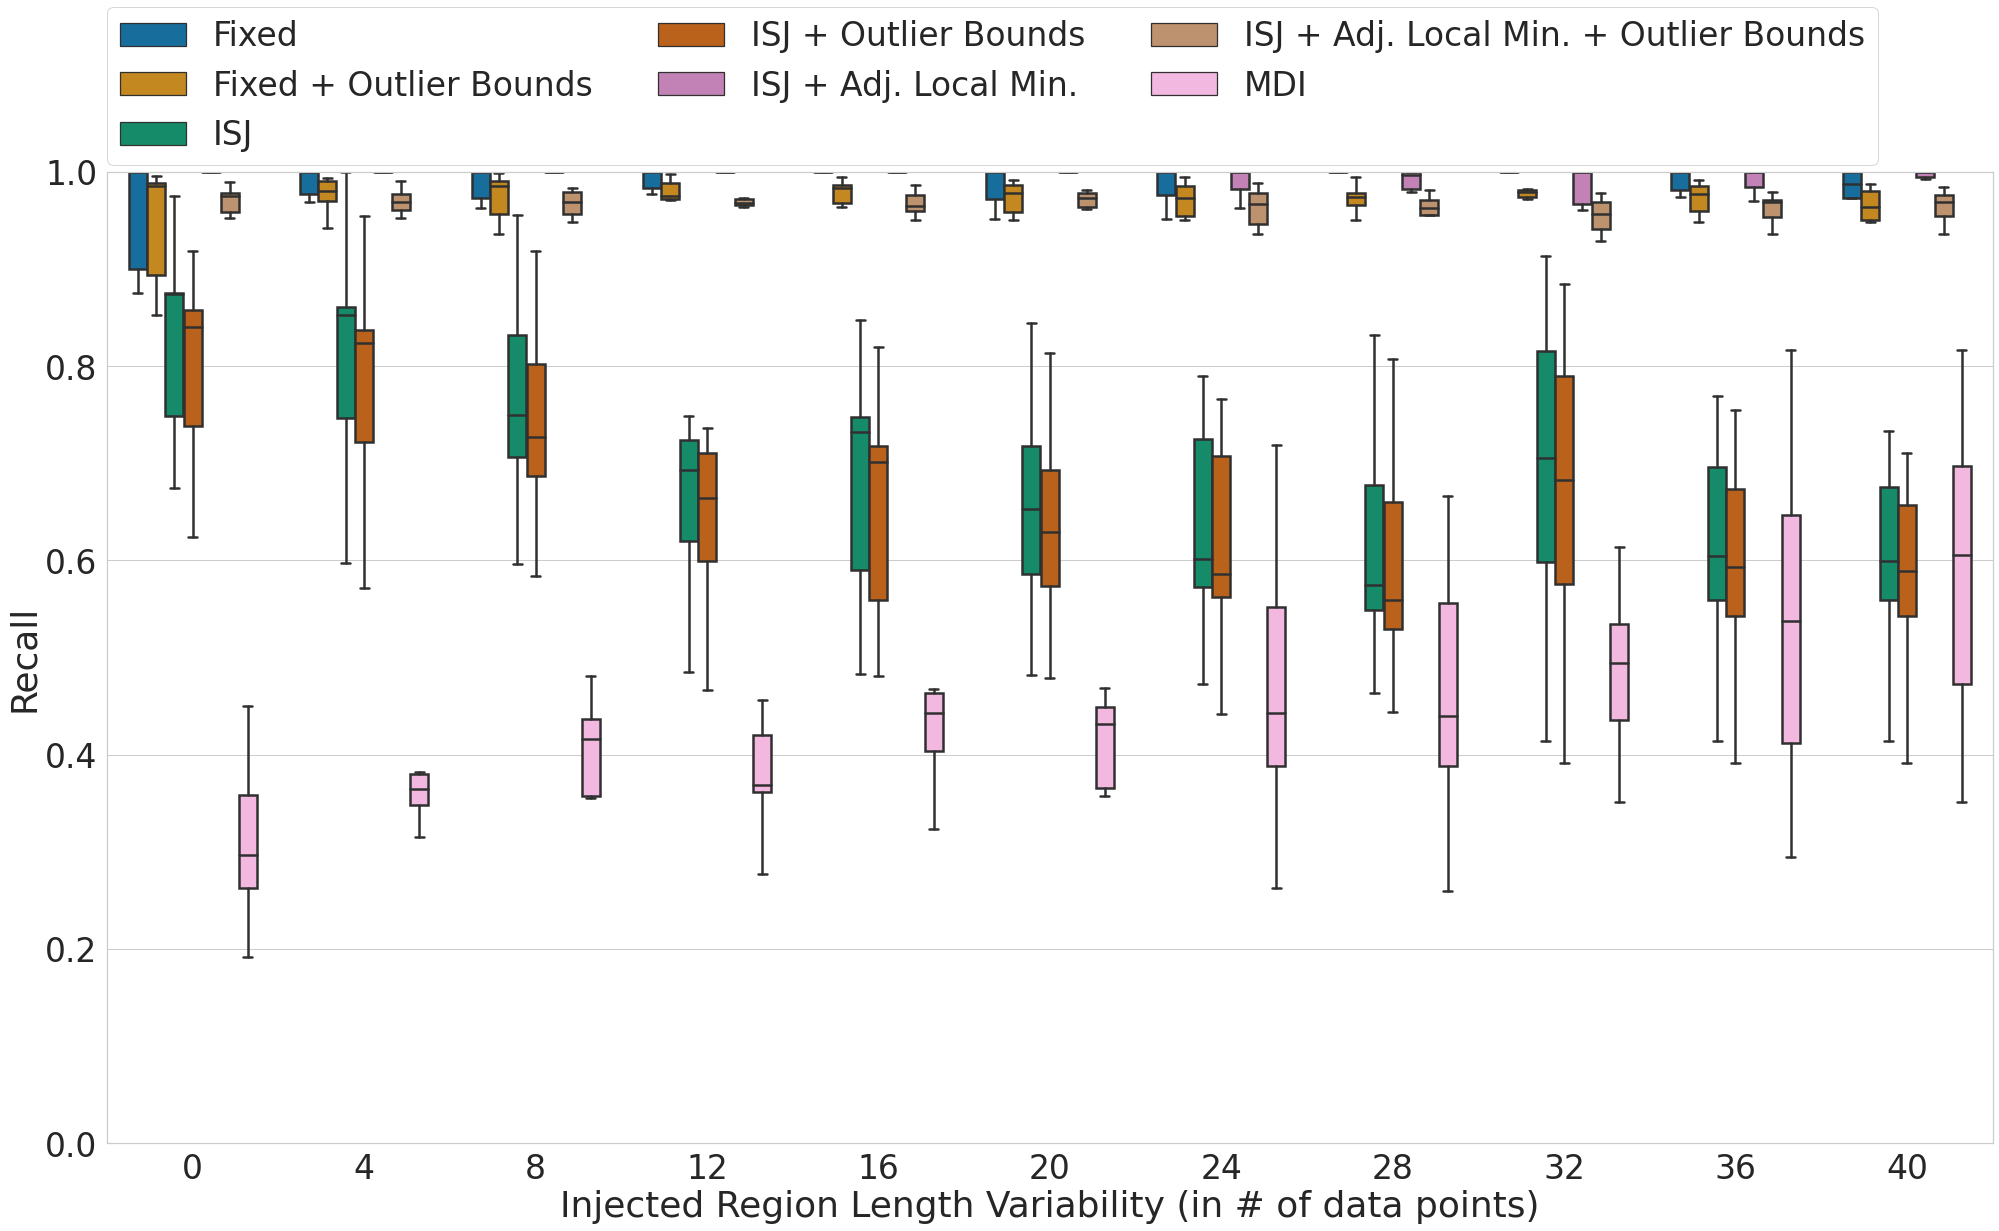

In [22]:
ax = sns.boxplot(x="region_length_variability", y="Recall", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette='colorblind')

plt.legend(bbox_to_anchor=(0, 1.17), loc=2, borderaxespad=0.,ncol=3)
plt.ylim(0,1);plt.xlabel("Injected Region Length Variability (in # of data points)");plt.ylabel("Recall");plt.title("");plt.tight_layout()
plt.savefig('figures/experiments/synthetic/offline/variable_region_length_recall.svg')
plt.savefig('figures/experiments/synthetic/offline/variable_region_length_recall.pdf')

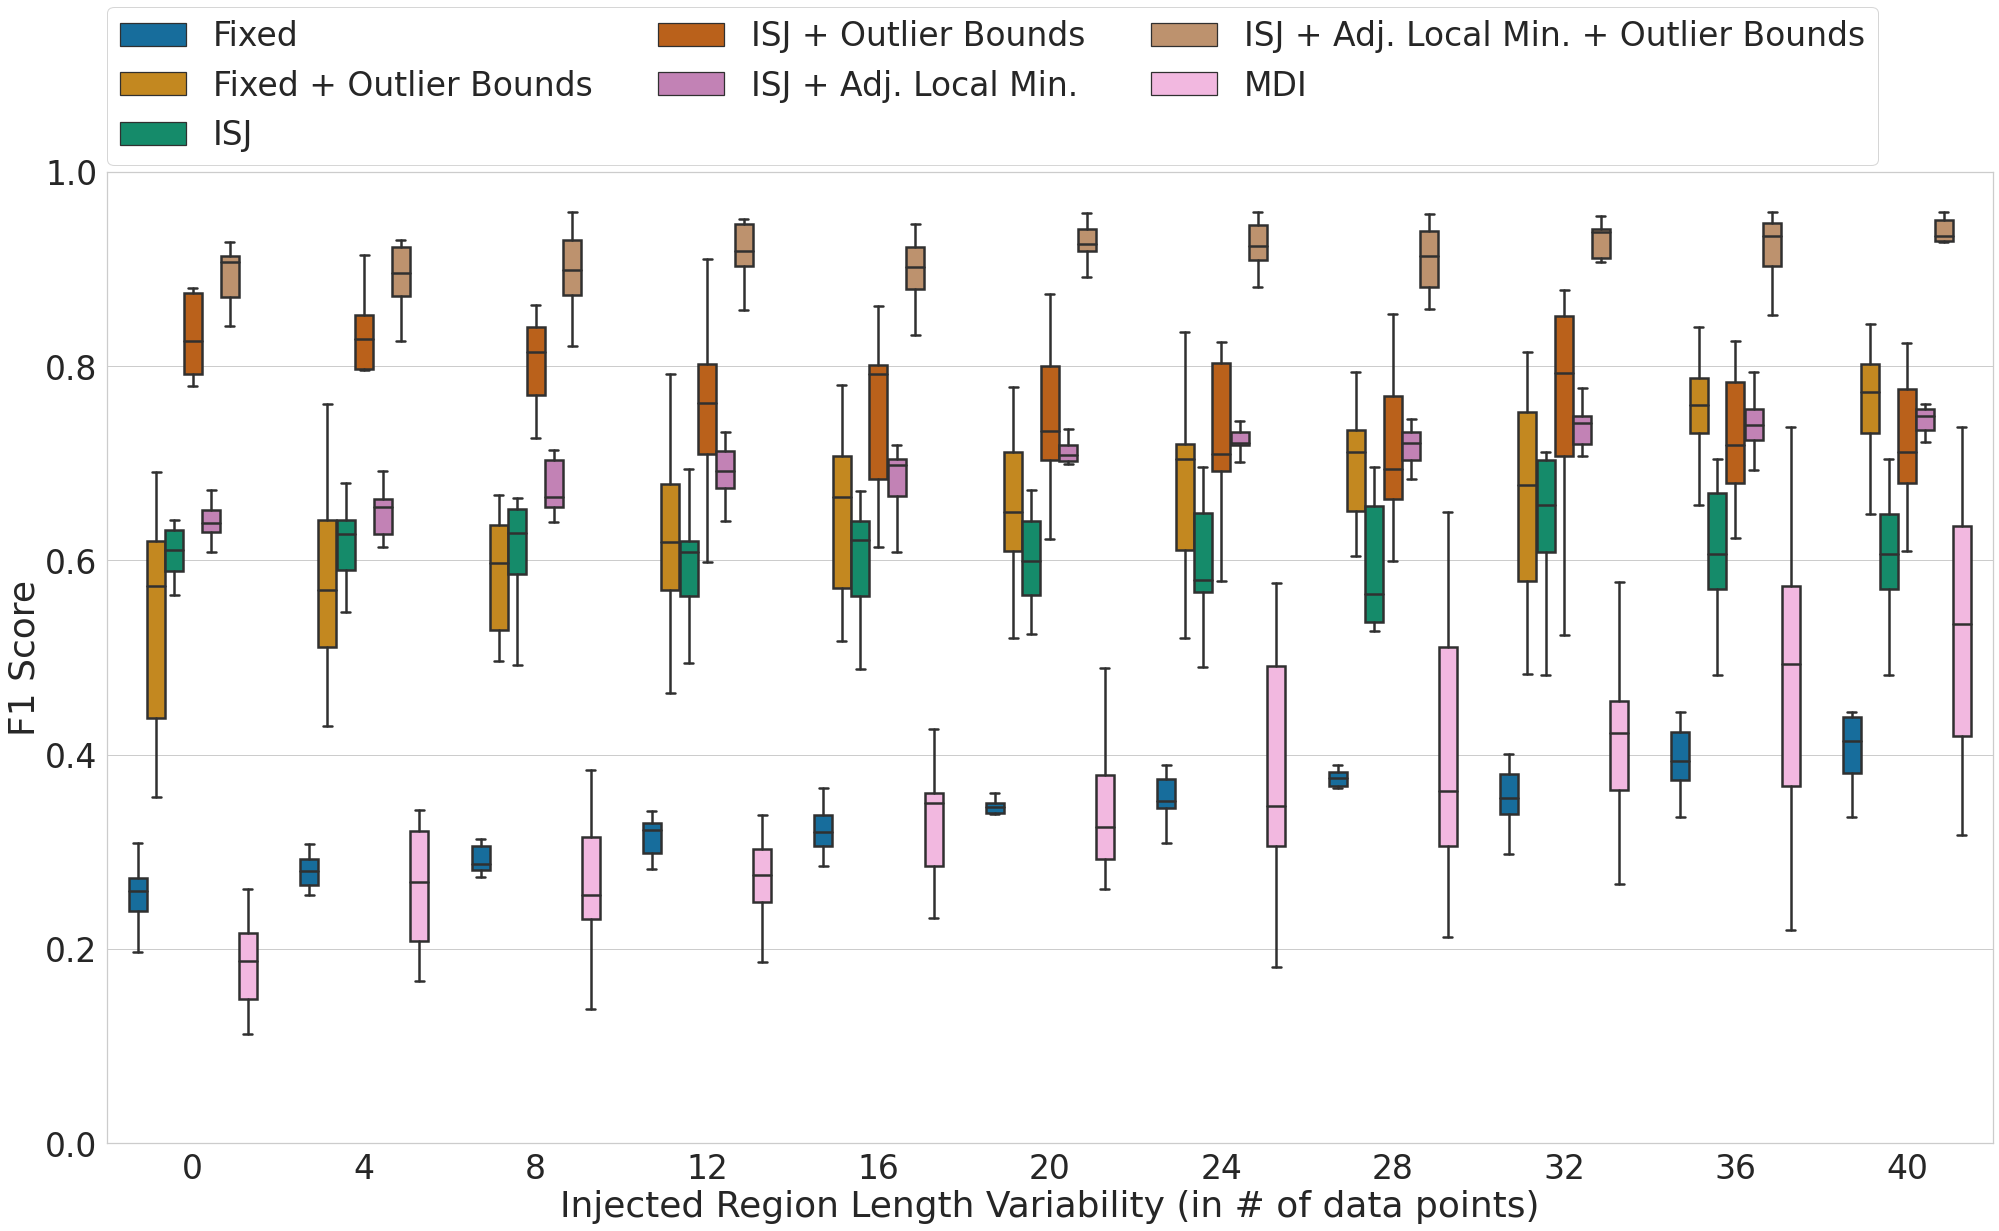

In [23]:
ax = sns.boxplot(x="region_length_variability", y="F1 Score", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette='colorblind')

plt.legend(bbox_to_anchor=(0, 1.17), loc=2, borderaxespad=0.,ncol=3)
plt.ylim(0,1);plt.xlabel("Injected Region Length Variability (in # of data points)");plt.ylabel("F1 Score");plt.title("");plt.tight_layout()
plt.savefig('figures/experiments/synthetic/offline/variable_region_length_f1_score.svg')
plt.savefig('figures/experiments/synthetic/offline/variable_region_length_f1_score.pdf')

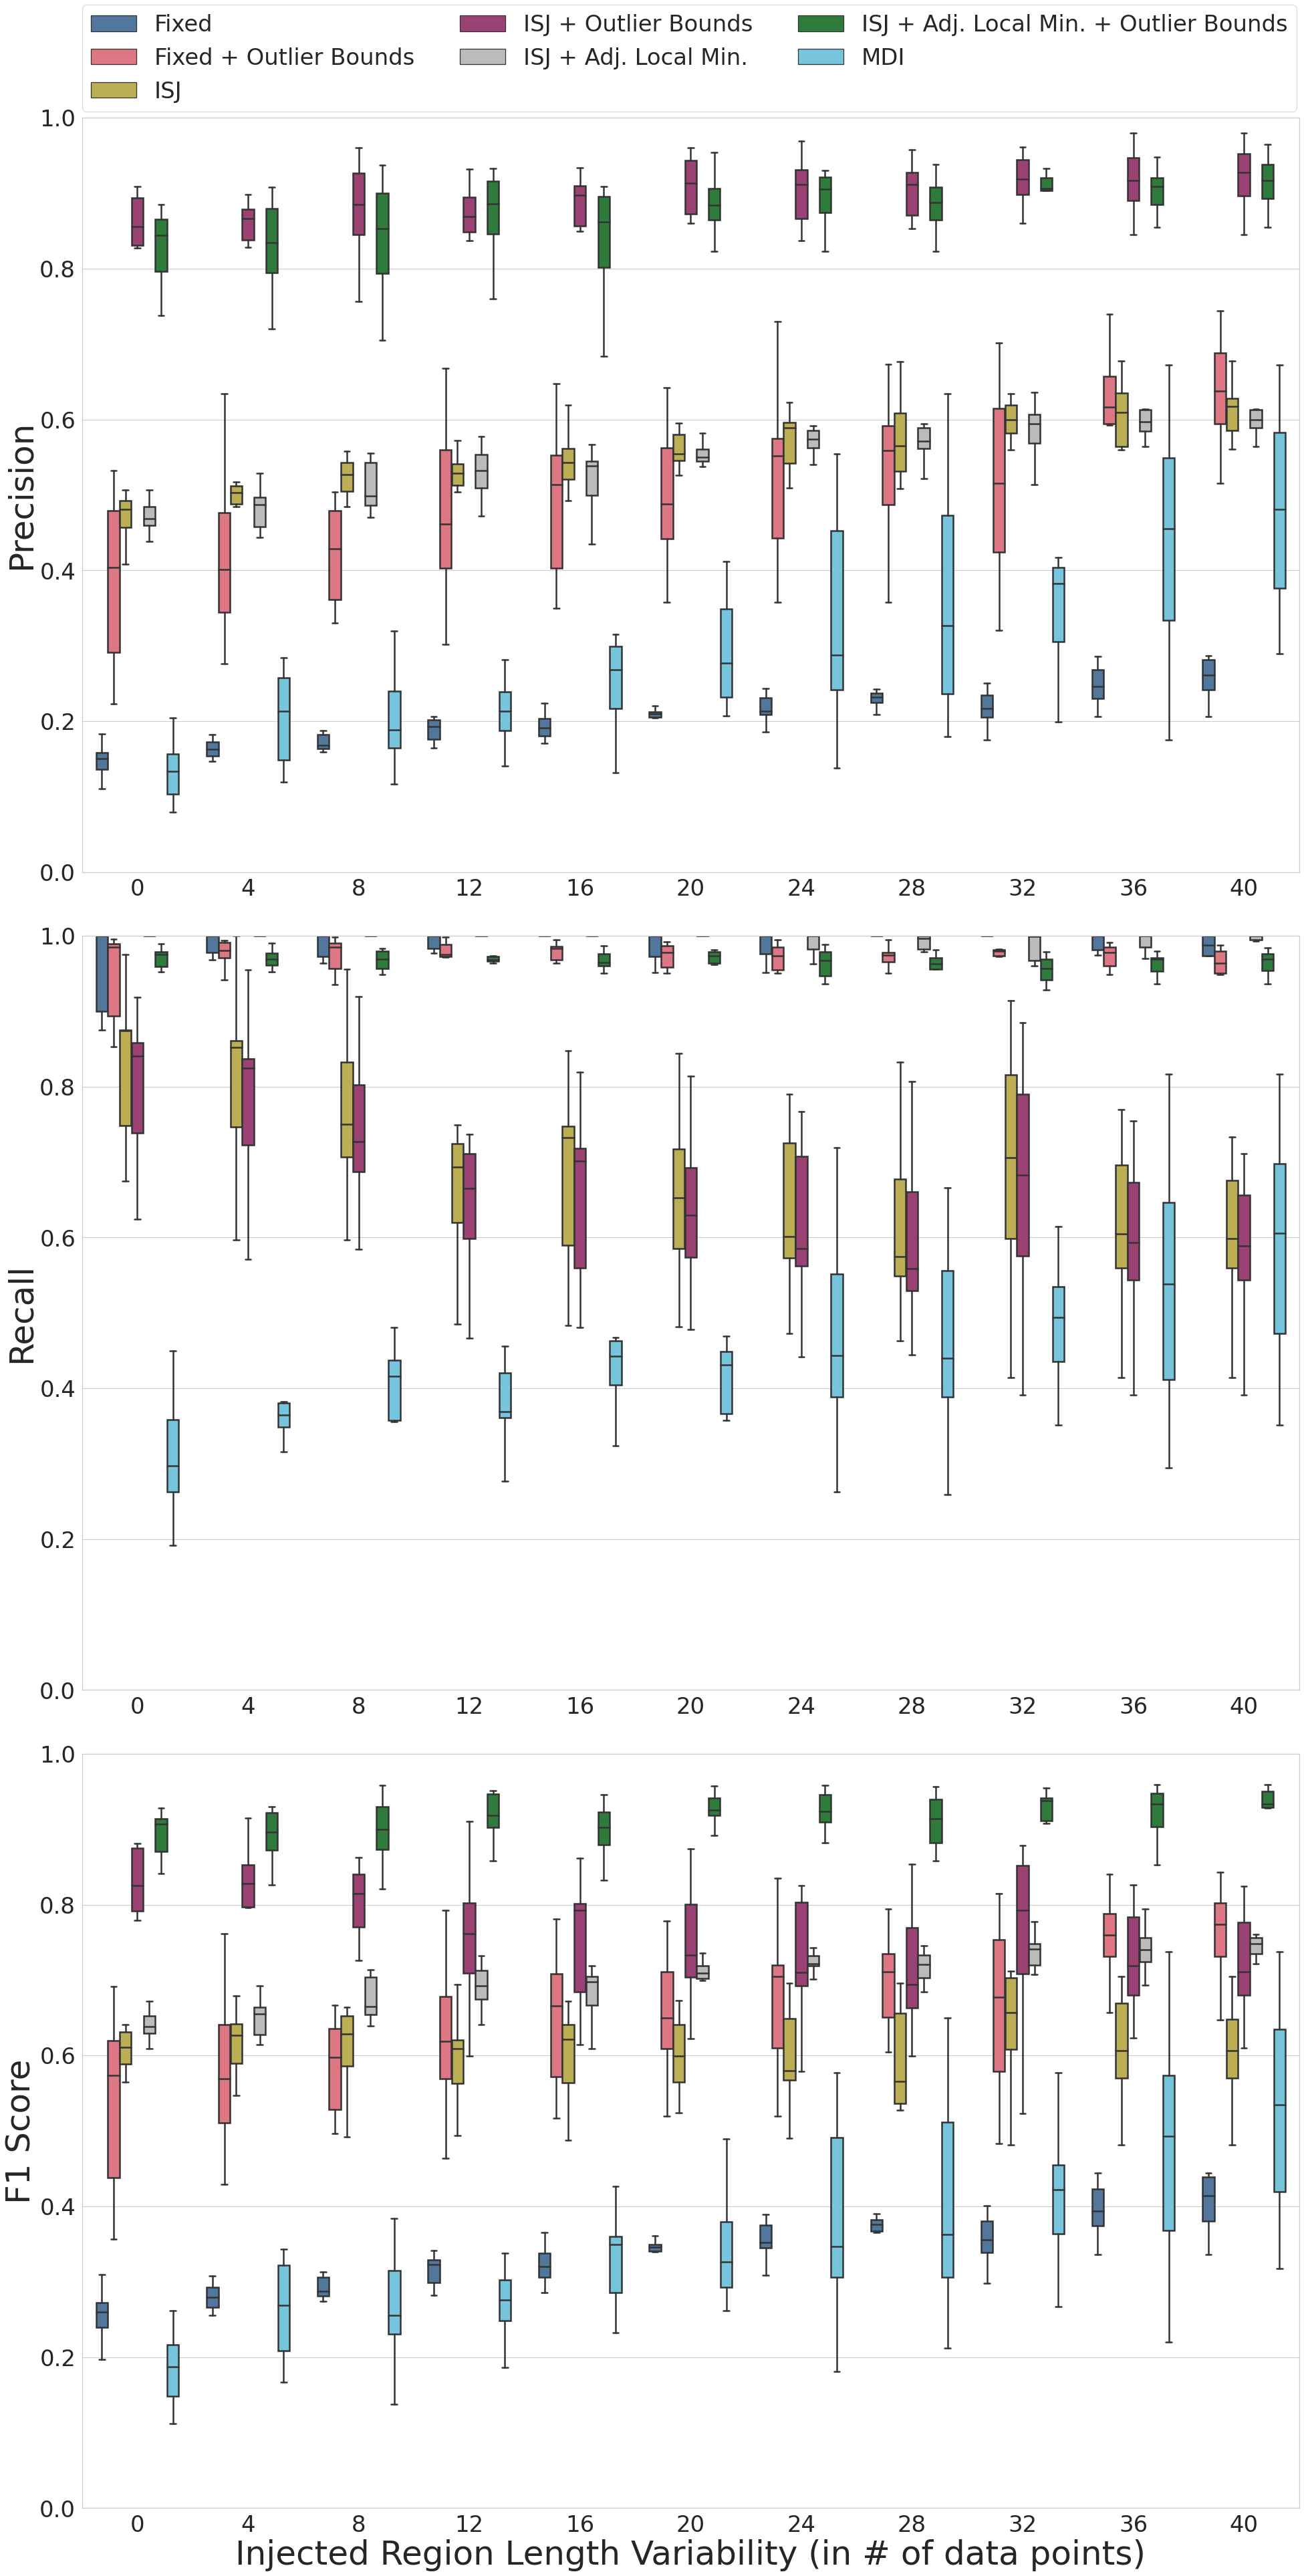

In [71]:
palette = ['#4477AA', '#EE6677', '#CCBB44', '#AA3377', '#BBBBBB', '#228833', '#66CCEE']

fig, axs = plt.subplots(3)
sns.set(rc={'figure.figsize':(30, 54)}, font_scale=3.08)
sns.set_style(style='whitegrid')

ax1 = sns.boxplot(ax=axs[0], x="region_length_variability", y="Precision", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette=sns.color_palette(palette, 7))
ax1.legend(bbox_to_anchor=(0, 1.15), loc=2, borderaxespad=0.,ncol=3)
ax1.set_xlabel('');ax1.set_ylim(0,1);ax1.set_ylabel('Precision', fontsize=50)

ax2 = sns.boxplot(ax=axs[1], x="region_length_variability", y="Recall", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette=sns.color_palette(palette, 7))
ax2.legend().remove();ax2.set_xlabel('');ax2.set_ylim(0,1);ax2.set_ylabel('Recall', fontsize=50)

ax3 = sns.boxplot(ax=axs[2], x="region_length_variability", y="F1 Score", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette=sns.color_palette(palette, 7))
ax3.legend().remove();ax3.set_xlabel("Injected Region Length Variability (in # of data points)", fontsize=50);ax3.set_ylim(0,1);ax3.set_ylabel('F1 Score', fontsize=50)

fig.subplots_adjust(hspace=0.1);plt.tight_layout()
plt.savefig('figures/experiments/synthetic/offline/variable_region_length_all.svg')
plt.savefig('figures/experiments/synthetic/offline/variable_region_length_all.pdf')

# Fixed Region Length and Variable Injection Rate

In [72]:
input_dir = '../synthetic_data/synthetic_experiments/variable_injection_rate/'

eval_df_columns = ['mode', 'seed', 'injection_rate', 'Precision', 'Recall', 'F1 Score']
eval_df = pd.DataFrame(columns=eval_df_columns)

for injection_rate_dir in tqdm(sorted(os.listdir(input_dir))):
    injection_rate = float(injection_rate_dir.split('_')[1])
    for seed in os.listdir(input_dir+injection_rate_dir+'/'):
        for mode in os.listdir(input_dir + injection_rate_dir + '/' + seed + '/evaluation/'):
            if mode == 'mdi':
                df = df = pd.read_pickle(input_dir + injection_rate_dir + '/' + seed + '/df.pickle')
                regions_df = pd.read_pickle(input_dir + injection_rate_dir + '/' + seed + '/regions_df.pickle')
                regions_df = utils.alerts.update_regions_df(regions_df, df)
                
                clusters_df = pd.read_pickle(input_dir + injection_rate_dir + '/' + seed + '/evaluation/'+ mode + '/mdi_clusters_df.pickle')
                clusters_df = clusters_df.sort_values(by='score', ascending=False).head(num_injected_regions)
                precision, recall, f1_score = get_eval_measures_offline(alerts_df=clusters_df, regions_df=regions_df)
                eval_df.loc[len(eval_df.index)] = [mode_to_mode_label[mode], seed, injection_rate, precision, recall, f1_score]
            else:
                df = pd.read_pickle(input_dir + injection_rate_dir + '/' + seed + '/evaluation/'+ mode + '/outputs/size_10080/df.pickle')

                regions_df = pd.read_pickle(input_dir + injection_rate_dir + '/' + seed + '/regions_df.pickle')
                regions_df = utils.alerts.update_regions_df(regions_df, df)

                clusters_df = pd.read_pickle(input_dir + injection_rate_dir + '/' + seed + '/evaluation/'+ mode + '/outputs/size_10080/clusters_df.pickle')
                clusters_df = clusters_df.sort_values(by='area', ascending=False).head(num_injected_regions)

                precision, recall, f1_score = get_eval_measures_offline(alerts_df=clusters_df, regions_df=regions_df)
                precision_outlier_bounds, recall_outlier_bounds, f1_score_outlier_bounds = get_eval_measures_offline(alerts_df=clusters_df, regions_df=regions_df, outlier_bounds=True)

                eval_df.loc[len(eval_df.index)] = [mode_to_mode_label[mode], seed, injection_rate, precision, recall, f1_score]
                eval_df.loc[len(eval_df.index)] = [mode_to_mode_label[mode] + ' + Outlier Bounds', seed, injection_rate, precision_outlier_bounds, recall_outlier_bounds, f1_score_outlier_bounds]

eval_df

100%|██████████| 13/13 [00:35<00:00,  2.71s/it]


,mode,seed,injection_rate,Precision,Recall,F1 Score
0,Fixed,seed7,0.4,0.102907,0.700000,0.179436
1,Fixed + Outlier Bounds,seed7,0.4,0.309741,0.700000,0.429454
2,MDI,seed7,0.4,0.051064,0.100000,0.067606
3,ISJ + Adj. Local Min.,seed7,0.4,0.356243,0.800000,0.492967
4,ISJ + Adj. Local Min. + Outlier Bounds,seed7,0.4,0.630313,0.758333,0.688422
...,...,...,...,...,...,...
905,MDI,seed3,1.0,0.209663,0.356250,0.263972
906,ISJ + Adj. Local Min.,seed3,1.0,0.413455,1.000000,0.585027
907,ISJ + Adj. Local Min. + Outlier Bounds,seed3,1.0,0.756775,0.979167,0.853725
908,ISJ,seed3,1.0,0.471852,0.837500,0.603621


In [73]:
modes_order=['Fixed', 'Fixed + Outlier Bounds', 'ISJ', 'ISJ + Outlier Bounds', 'ISJ + Adj. Local Min.', 'ISJ + Adj. Local Min. + Outlier Bounds', 'MDI']
eval_df['mode'] = pd.Categorical(eval_df['mode'], categories=modes_order)

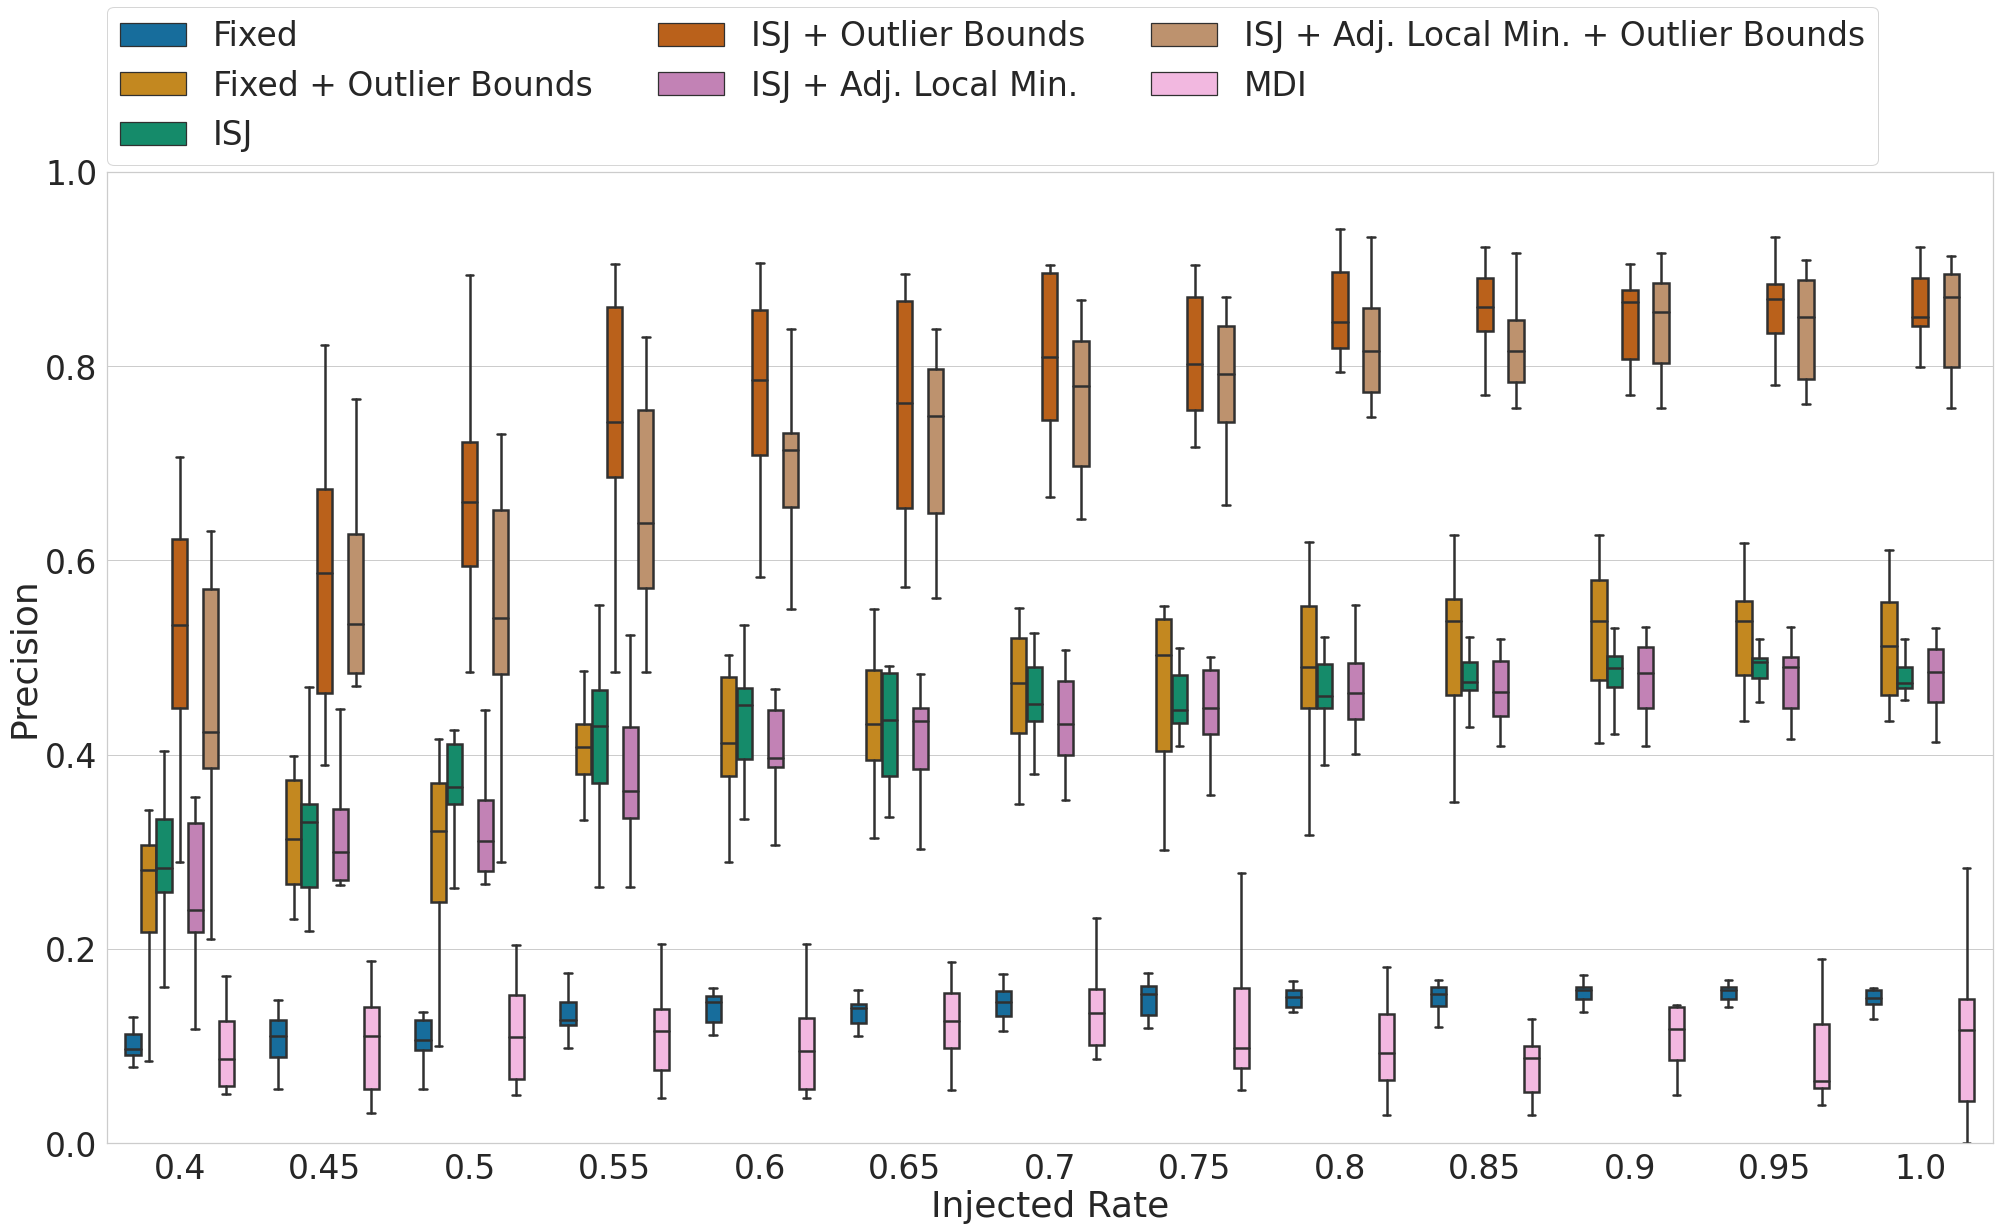

In [74]:
sns.set(rc={'figure.figsize':(30, 18)}, font_scale=3)
sns.set_style(style='whitegrid')
ax = sns.boxplot(x="injection_rate", y="Precision", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette='colorblind')

plt.legend(bbox_to_anchor=(0, 1.17), loc=2, borderaxespad=0.,ncol=3)
plt.ylim(0,1);plt.xlabel("Injected Rate");plt.ylabel("Precision");plt.title("");plt.tight_layout()
plt.savefig('figures/experiments/synthetic/offline/variable_injection_rate_precision.svg')
plt.savefig('figures/experiments/synthetic/offline/variable_injection_rate_precision.pdf')

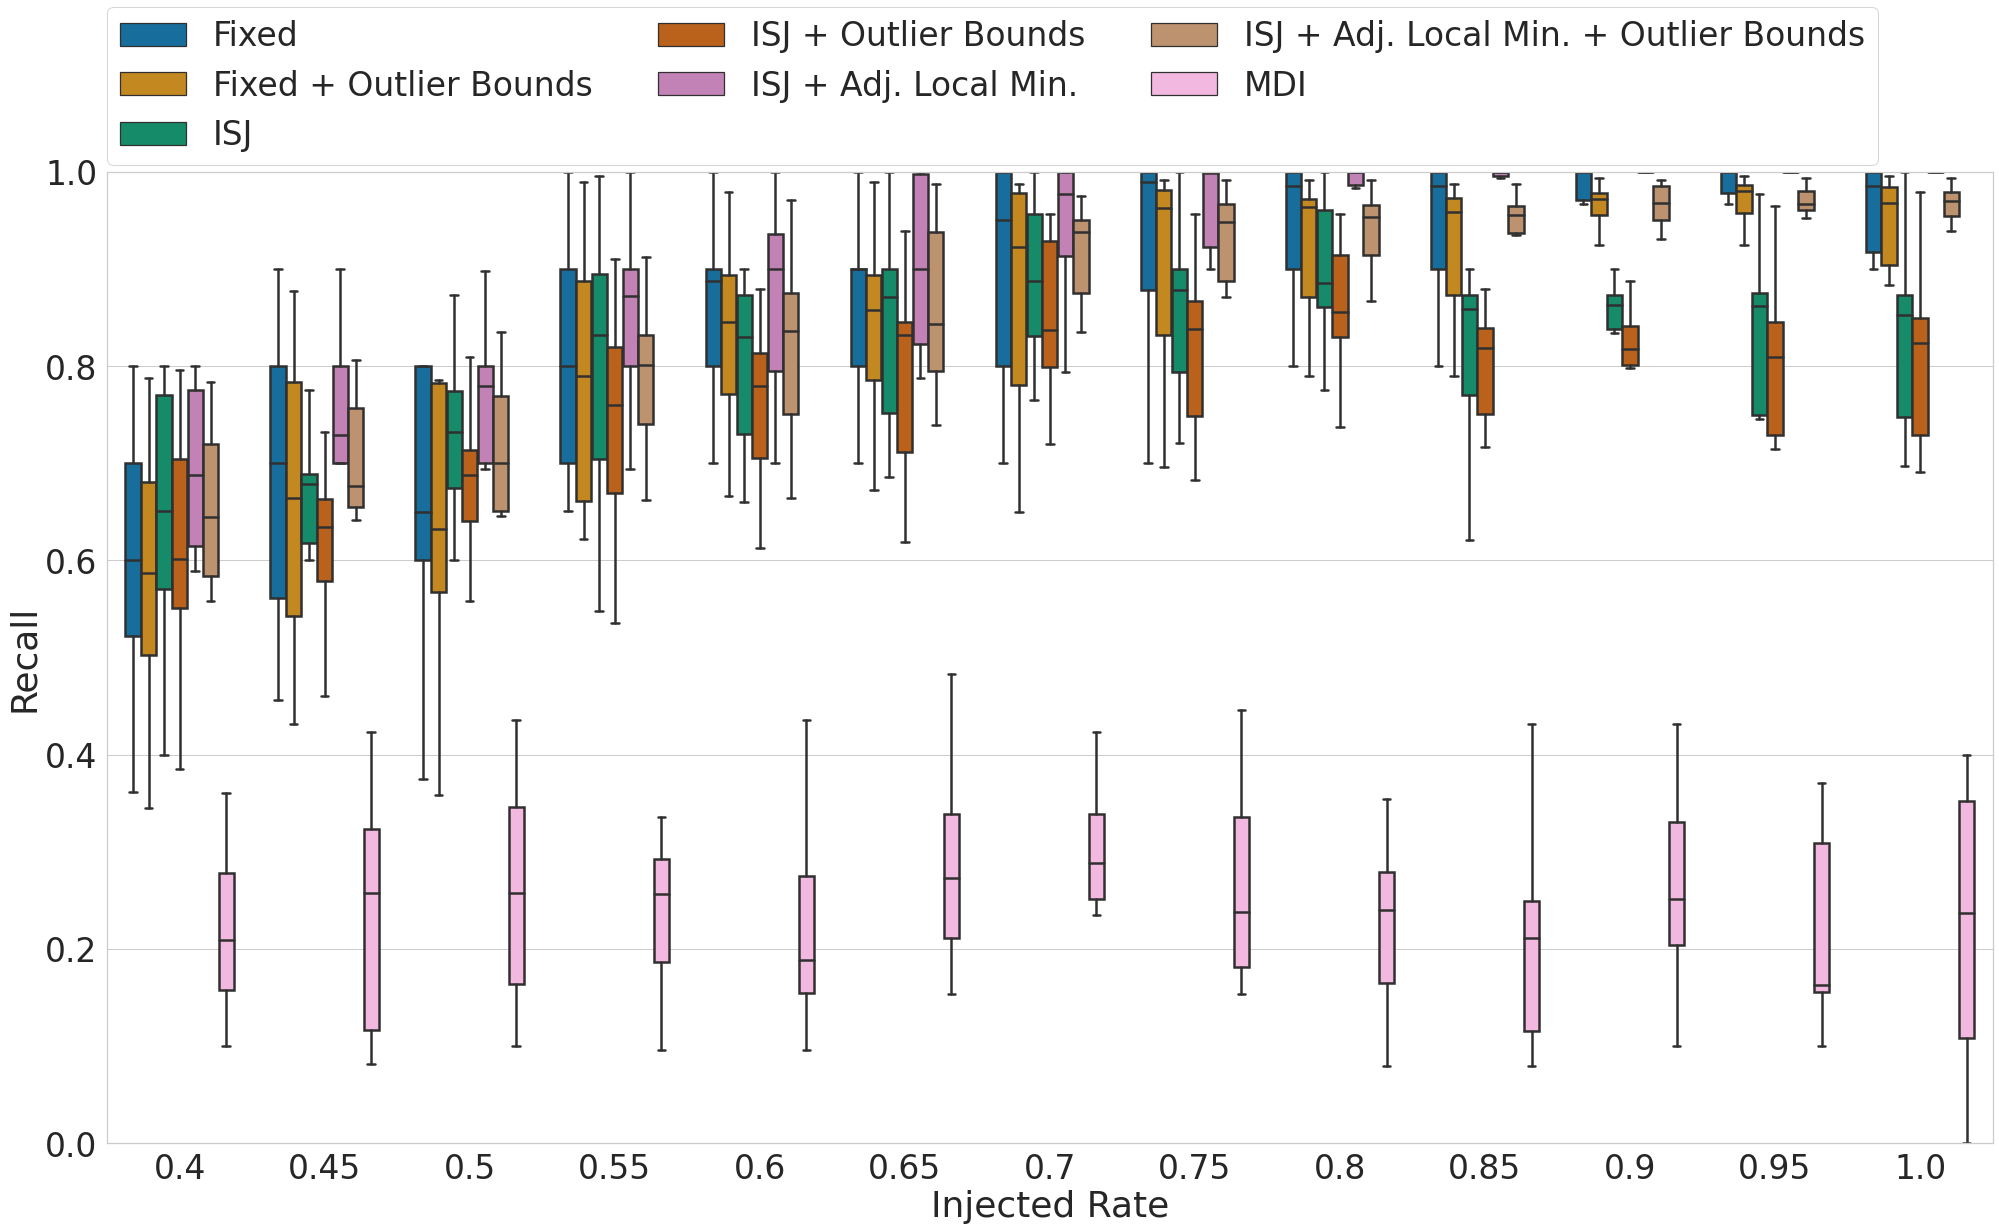

In [75]:
sns.set(rc={'figure.figsize':(30, 18)}, font_scale=3)
sns.set_style(style='whitegrid')
ax = sns.boxplot(x="injection_rate", y="Recall", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette='colorblind')

plt.legend(bbox_to_anchor=(0, 1.17), loc=2, borderaxespad=0.,ncol=3)
plt.ylim(0,1);plt.xlabel("Injected Rate");plt.ylabel("Recall");plt.title("");plt.tight_layout()
plt.savefig('figures/experiments/synthetic/offline/variable_injection_rate_recall.svg')
plt.savefig('figures/experiments/synthetic/offline/variable_injection_rate_recall.pdf')

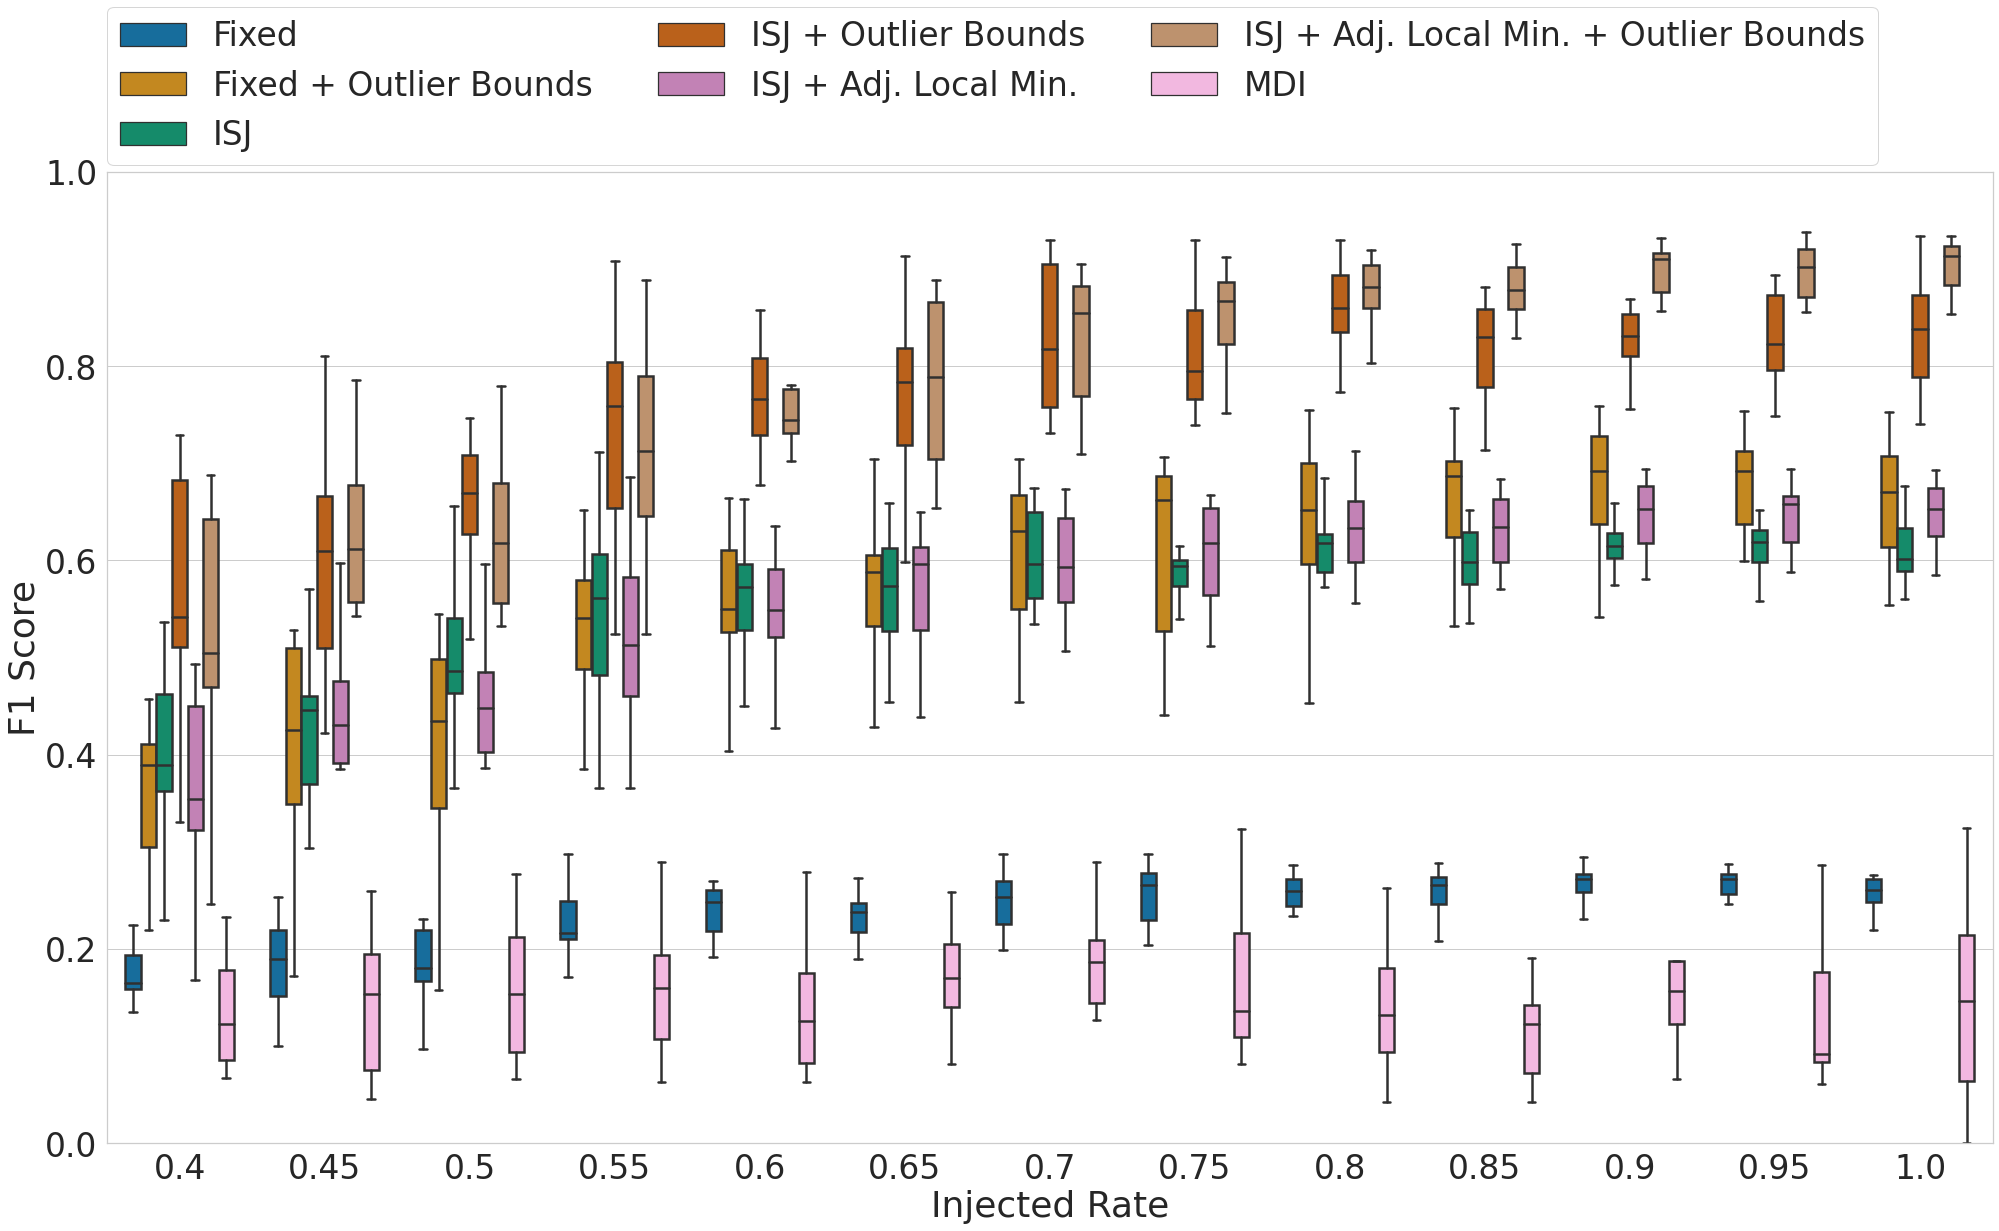

In [76]:
sns.set(rc={'figure.figsize':(30, 18)}, font_scale=3)
sns.set_style(style='whitegrid')
ax = sns.boxplot(x="injection_rate", y="F1 Score", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette='colorblind')

plt.legend(bbox_to_anchor=(0, 1.17), loc=2, borderaxespad=0.,ncol=3)
plt.ylim(0,1);plt.xlabel("Injected Rate");plt.ylabel("F1 Score");plt.title("");plt.tight_layout()
plt.savefig('figures/experiments/synthetic/offline/variable_injection_rate_f1_score.svg')
plt.savefig('figures/experiments/synthetic/offline/variable_injection_rate_f1_score.pdf')

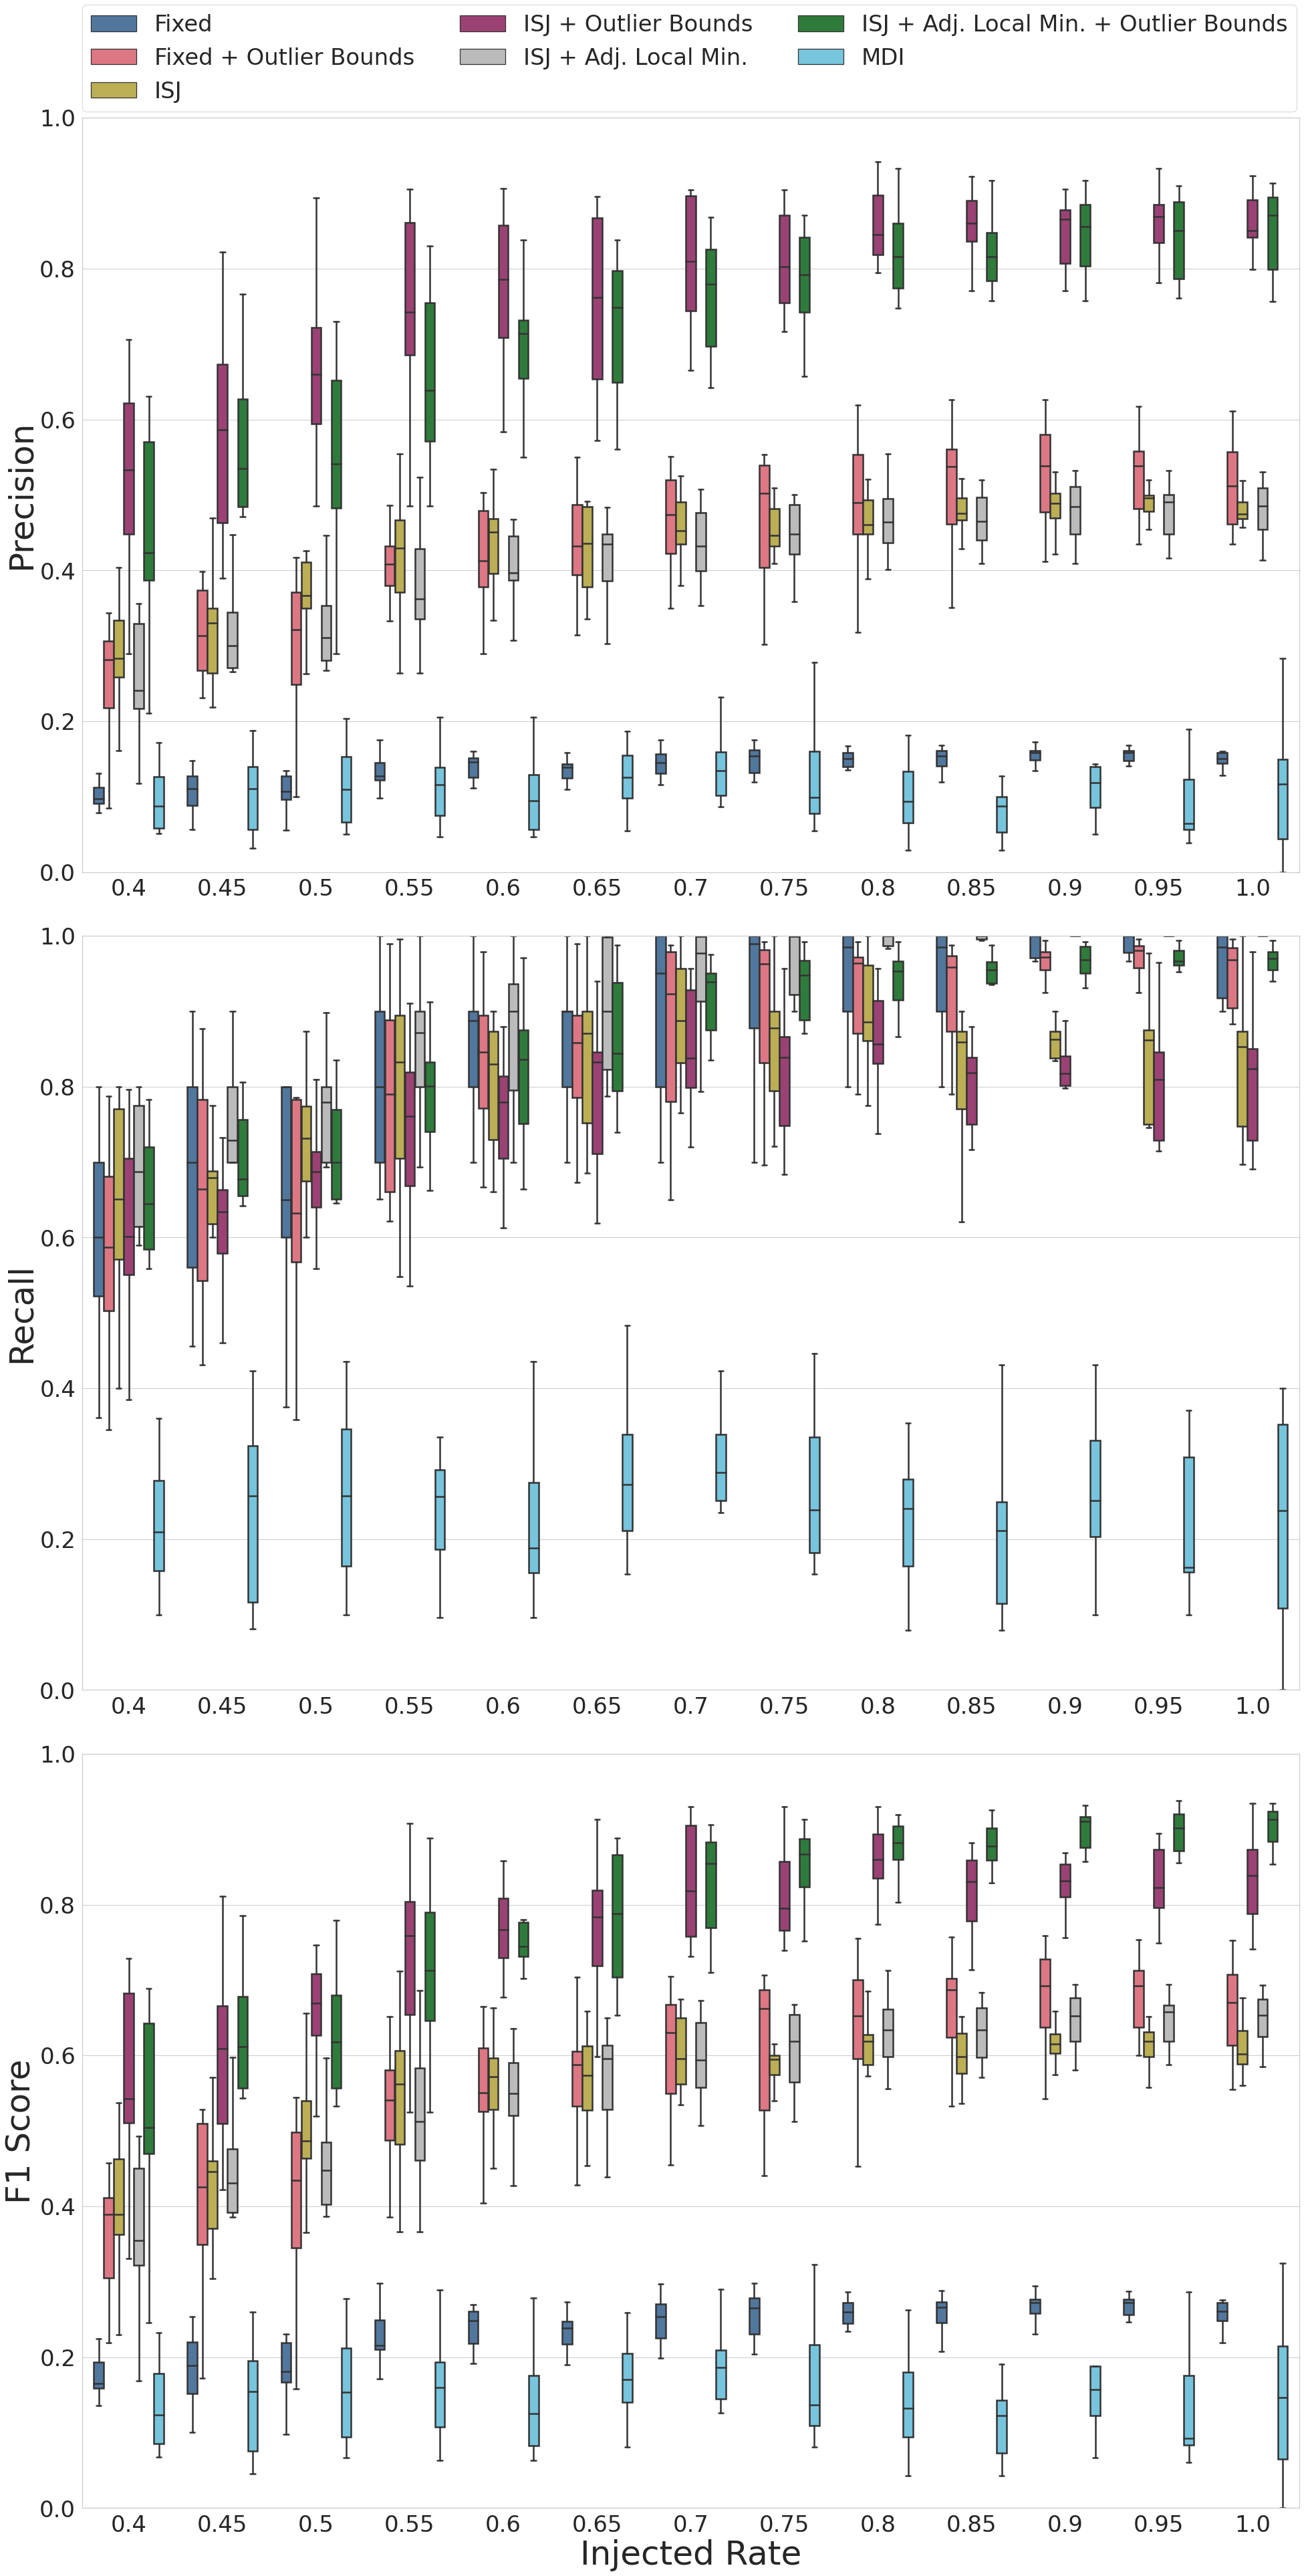

In [79]:
palette = ['#4477AA', '#EE6677', '#CCBB44', '#AA3377', '#BBBBBB', '#228833', '#66CCEE']

fig, axs = plt.subplots(3)
sns.set(rc={'figure.figsize':(30, 54)}, font_scale=3.08)
sns.set_style(style='whitegrid')

ax1 = sns.boxplot(ax=axs[0], x="injection_rate", y="Precision", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette=sns.color_palette(palette, 7))
ax1.legend(bbox_to_anchor=(0, 1.15), loc=2, borderaxespad=0.,ncol=3)
ax1.set_xlabel('');ax1.set_ylim(0,1);ax1.set_ylabel('Precision', fontsize=50)

ax2 = sns.boxplot(ax=axs[1], x="injection_rate", y="Recall", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette=sns.color_palette(palette, 7))
ax2.legend().remove();ax2.set_xlabel('');ax2.set_ylim(0,1);ax2.set_ylabel('Recall', fontsize=50)

ax3 = sns.boxplot(ax=axs[2], x="injection_rate", y="F1 Score", hue='mode', data=eval_df, showfliers=False, linewidth=2.5, width=0.75, palette=sns.color_palette(palette, 7))
ax3.legend().remove();ax3.set_xlabel("Injected Rate", fontsize=50);ax3.set_ylim(0,1);ax3.set_ylabel('F1 Score', fontsize=50)

fig.subplots_adjust(hspace=0.1);plt.tight_layout()
plt.savefig('figures/experiments/synthetic/offline/injected_rate_all.svg')
plt.savefig('figures/experiments/synthetic/offline/injected_rate_all.pdf')

# Testing

In [15]:
df = pd.read_pickle('../synthetic_data/synthetic_experiments/all_outlier_types_098/seed1/df.pickle')
mdi_clusters_df = pd.read_pickle('../synthetic_data/synthetic_experiments/all_outlier_types_098/seed1/evaluation/mdi/mdi_clusters_df.pickle')
mdi_clusters_df

,cluster_id,unix_start,unix_end,time_length,score
0,0,1.618844e+09,1.619014e+09,169200.0,86.089375
1,1,1.624590e+09,1.624759e+09,169200.0,74.298649
2,2,1.617365e+09,1.617534e+09,169200.0,73.913163
3,3,1.620086e+09,1.620245e+09,158400.0,72.589504
4,4,1.602850e+09,1.602979e+09,129600.0,70.434712
5,5,1.613401e+09,1.613570e+09,169200.0,70.248961
6,6,1.596488e+09,1.596643e+09,154800.0,68.567990
7,7,1.614348e+09,1.614485e+09,136800.0,66.501047
8,8,1.592262e+09,1.592410e+09,147600.0,66.316223
9,9,1.607072e+09,1.607216e+09,144000.0,65.786583


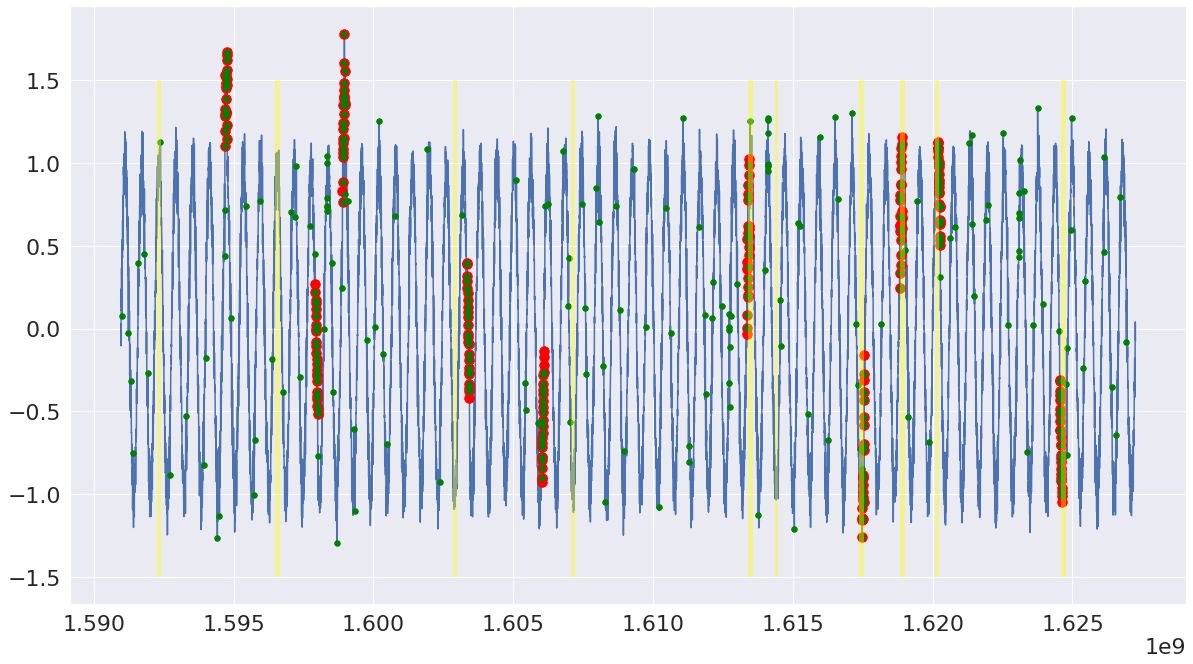

In [16]:
fig, axs = plt.subplots(1)

axs.plot(df['unix_time'], df['measure'])
axs.scatter(df[df['is_outlier']==1]['unix_time'].values, df[df['is_outlier']==1]['measure'].values, s=90, c='red', zorder=10, label='True Injected Outliers')
axs.scatter(df[df['raw_voting_score']>0]['unix_time'].values, df[df['raw_voting_score']>0]['measure'].values, s=30, c='green', zorder=10, label='Detected Outliers')

for _, alert in mdi_clusters_df.iterrows():
    axs.add_patch(patches.Rectangle((alert['unix_start'], -1.5), width=alert['unix_end']-alert['unix_start'], height=3, linewidth=0, color='yellow', zorder=10, alpha=0.40))